In [1]:
import os
import numpy as np
import hnswlib
import matplotlib.pyplot as plt
import pandas as pd
import utils_sim as utils
from tqdm import tqdm
import ast

os.makedirs("results", exist_ok=True)

# Paths to data
mapped_imgs_dir = "../data/mapped_images"
random_imgs_dir = "../data/random_images"
mapped_meta_path = "../data/csv/mapped_metadata.csv"
random_meta_path = "../data/csv/random_metadata.csv"

# Load metadata
mapped_meta = pd.read_csv(mapped_meta_path)
random_meta = pd.read_csv(random_meta_path)

# User-specified number of environments to test
test_envs = 2  # Adjust as needed
all_envs = list(set(random_meta["env_idx"]))
selected_envs = all_envs[:test_envs]

# Filter data based on selected environments
filtered_mapped_meta = mapped_meta[mapped_meta["env_idx"].isin(selected_envs)]
filtered_random_meta = random_meta[random_meta["env_idx"].isin(selected_envs)]


/Users/jacksmith/miniconda3/envs/vpr_env/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jacksmith/miniconda3/envs/vpr_env/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/jacksmith/miniconda3/envs/vpr_env/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/jacksmith/miniconda3/envs/vpr_env/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/jacksmith/miniconda3/envs/vpr_env/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/jacksmith/miniconda3/envs/vpr_env/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/jacksmith/miniconda3/envs/vpr_env/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warni

In [ ]:
# Initialize models
models = ["netvlad", "alexnet", "mobilenet", "cohog"]
# models = ["cohog"]

# Initialize models once
model_instances = {model: utils.load_model(model) for model in models}

# Generate feature vectors for mapped images
print("Generating feature vectors for mapped images...")
mapped_features = {}

for model in models:
    with tqdm(total=len(filtered_mapped_meta), desc=f"Extracting {model} features", dynamic_ncols=True) as pbar:
        mapped_features[model] = utils.create_feature_vectors(
            mapped_imgs_dir, filtered_mapped_meta, model, model_instances[model], pbar
        )

# Generate feature vectors for random images
print("Generating feature vectors for random images...")
random_features = {}

for model in models:
    with tqdm(total=len(filtered_random_meta), desc=f"Extracting {model} features", dynamic_ncols=True) as pbar:
        random_features[model] = utils.create_feature_vectors(
            random_imgs_dir, filtered_random_meta, model, model_instances[model], pbar
        )





Generating feature vectors for mapped images...


Extracting cohog features: 100%|██████████| 160/160 [00:59<00:00,  2.67it/s]


Generating feature vectors for random images...


Extracting cohog features: 100%|██████████| 160/160 [00:58<00:00,  2.75it/s]


In [3]:

# Initialize and populate HNSW indices
hnsw_indices = utils.create_hnsw(mapped_features, models)


🔄 Initializing HNSW for cohog...
🔍 Adding 160 vectors to cohog HNSW index...
✅ HNSW index created for cohog | Dimension: 3901440 | Elements: 160


In [4]:
# Evaluate recall@n for k1 to k25
results = {model: {f"k{i}": 0 for i in range(1, 26)} for model in models}

for model in models:
    total_queries = len(random_features[model])  # Set correctly per model
    print(f"total queries: {total_queries}")
    print(f"Evaluating {model}...")

    # Extract the HNSW index and the mapping
    hnsw, image_id_map = hnsw_indices[model]
    id_to_image = {v: k for k, v in image_id_map.items()}  # Reverse mapping

    # Wrap the query iteration with tqdm for progress tracking
    for img_id, query_vector in tqdm(random_features[model].items(), total=total_queries, desc=f"Testing {model}"):

        # Perform nearest neighbor search
        indices, _ = hnsw.knn_query(query_vector, k=25)

        # Convert retrieved integer IDs back to image filenames
        retrieved_images = [id_to_image[i] for i in indices[0]]

        # Extract valid neighbors
        valid_neighbours_str = filtered_random_meta[filtered_random_meta["image_idx"] == img_id]["valid_neighbours"].values[0]
        correct_matches = set(valid_neighbours_str.split(";"))  # Convert to a set

        # Evaluate recall@n
        for k in range(1, 26):
            if retrieved_images[k-1] in correct_matches:  # Found a correct match at position k
                for j in range(k, 26):  # Increment recall for all k >= found position
                    results[model][f"k{j}"] += 1
                break  # Stop checking further, move to next image

    # Normalize recall values
    for k in range(1, 26):
        results[model][f"k{k}"] /= total_queries  # Convert to recall percentage if needed


total queries: 160
Evaluating cohog...


Testing cohog: 100%|██████████| 160/160 [02:09<00:00,  1.24it/s]


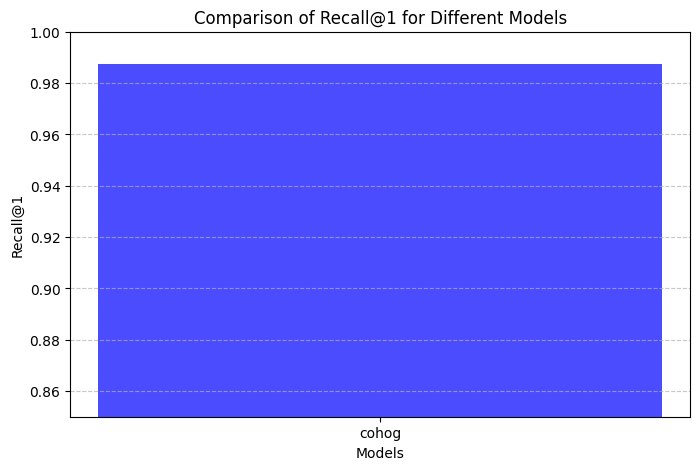

In [5]:
# Plot Recall@1 for different models
plt.figure(figsize=(8, 5))

# Extract Recall@1 values
recall_at_1 = [results[model]["k1"] for model in models]

# Plot a bar chart
plt.bar(models, recall_at_1, color="blue", alpha=0.7)

# Labels and title
plt.xlabel("Models")
plt.ylabel("Recall@1")
plt.title("Comparison of Recall@1 for Different Models")
plt.ylim(0.85, 1)  # Assuming recall is between 0 and 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save the figure
plt.savefig("results/recall_at_1.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


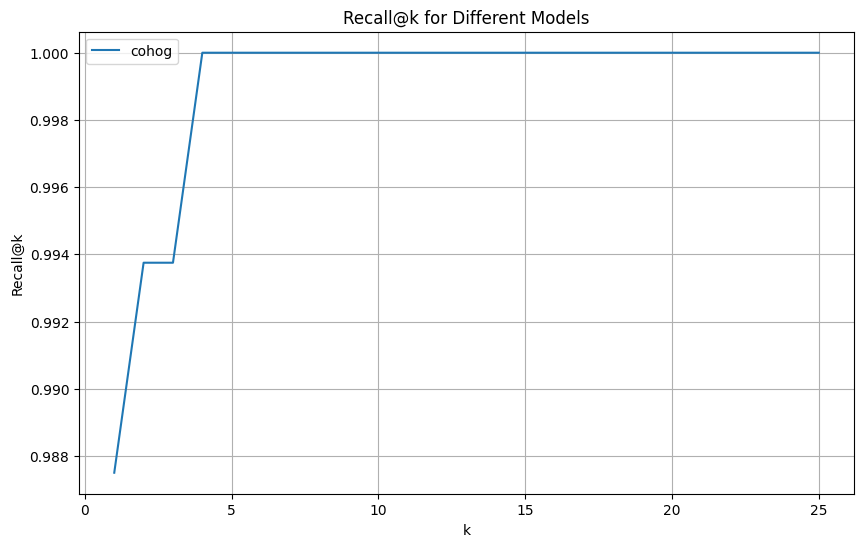

In [6]:
# Plot recall@n
plt.figure(figsize=(10, 6))
for model in models:
    recall_values = [results[model][f"k{k}"] for k in range(1, 26)]
    plt.plot(range(1, 26), recall_values, label=model)

plt.xlabel("k")
plt.ylabel("Recall@k")
plt.title("Recall@k for Different Models")
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("results/recall_at_k.png", dpi=300, bbox_inches='tight')

# Optionally display the plot
plt.show()